# EOPF STAC Demo

**Author(s):** Gisela Romero Candanedo, Julia Wagemann  
**Affiliation:** thriveGEO  
**Contact:** gisela@thrivegeo.com

---



## Introduction

In this section, we will dive into the programmatic access of EOPF Zarr Collections available in the [EOPF Sentinel Zarr Sample Service STAC Catalog](https://stac.browser.user.eopf.eodc.eu/?.language=en). We will introduce Python libraries that enable us to effectively access and search through STAC.

<div style="border: 2.5px solid #999; padding: 1em; border-radius: 6px; background-color: #eaeaea;">
  <strong>Objectives:</strong>
  <ul>
    <li> 🔍 How to **programmatically browse** through available collections available via the EOPF Zarr STAC Catalog</li>
    <li> 📊 Understanding **collection metadata** in user-friendly terms</li>
    <li> 🎯 **Searching for specific data** with help of the `pystac` and `pystac-client` libraries</li>
  </ul>
</div>


> **Disclaimer**  
> This notebook demonstrates the use of open source software and is intended for educational and illustrative purposes only. All software used is subject to its respective licenses. The authors and contributors of this notebook make no guarantees about the accuracy, reliability, or suitability of the content or included code. Use at your own discretion and risk. No warranties are provided, either express or implied.

---

## Table of Contents

<ul style="list-style-type:none; padding-left: 0;">
<li>🔹 <a href="#Setup"><strong>Setup</strong></a></li>
<li>🔹 <a href="#Establish-a-connection-to-the-EOPF-Zarr-STAC-Catalog"><strong>Establish a connection to the EOPF Zarr STAC Catalog</strong></a></li>
<li>🔹 <a href="#Explore-available-collections"><strong>Explore available collections</strong></a></li>
<li>🔹 <a href="#Searching-inside-the-EOPF-STAC-API"><strong>Searching inside the EOPF STAC API</strong></a></li>
<li>🔹 <a href="#Retrieve-Asset-URLs-for-accessing-the-data"><strong>Retrieve Asset URLs for accessing the data</strong></a></li>
<li>🔹 <a href="#Examining-Dataset-Structure"><strong>Examining Dataset Structure</strong></a></li>
<li>🔹 <a href="#Visualising-the-RGB-quicklook-composite"><strong>Visualising the RGB quicklook composite</strong></a></li>
<li>🔹 <a href="#Creating-our-own-RGB"><strong>Creating our own RGB</strong></a></li>
<li>🔹 <a href="#Chunking-structure"><strong>Chunking structure</strong></a></li>
<li>🔹 <a href="#Now-it-is-your-turn"><strong>💪 Now it is your turn</strong></a></li>
<li>🔹 <a href="#Conclusion"><strong>Conclusion</strong></a></li>
</ul>

<hr>


## Setup

For this tutorial, we will make use of the [pystac](https://pystac.readthedocs.io/en/stable/) and [pystac_client](https://pystac-client.readthedocs.io/en/latest/api.html) Python libraries that facilitate the programmatic access and efficient search of a STAC Catalog.

<hr>

#### Import libraries

In [1]:
from pystac_client import Client, CollectionClient
from pystac import Collection, MediaType
import datetime
from dateutil.tz import tzutc
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os

#### Helper functions

##### `list_found_elements`
As we are expecting to visualise several elements that will be stored in lists, we define a function that will allow us retrieve item `id`'s and collections `id`'s for further retrieval.

In [2]:
def list_found_elements(search_result):
    id = []
    coll = []
    for item in search_result.items(): #retrieves the result inside the catalogue.
        id.append(item.id)
        coll.append(item.collection_id)
    return id , coll

##### `normalisation_str_gm()`

Applies percentile-based contrast stretching and gamma correction to a band.

Recieves:

- `band_array` : the extracted `xarray` for the selected band
- `p_min` : percentile min value
- `p_max`: percentile max value
- `gamma_val`: gamma correction

In [3]:
def normalisation_str_gm(band_array, p_min, p_max, gamma_val):

    # Calculate min and max values based on percentiles for stretching
    min_val = np.percentile(band_array[band_array > 0], p_min) if np.any(band_array > 0) else 0
    max_val = np.percentile(band_array[band_array > 0], p_max) if np.any(band_array > 0) else 1

    # Avoid division by zero if min_val equals max_val
    if max_val == min_val:
        stretched_band = np.zeros_like(band_array, dtype=np.float32)
    else:
        # Linear stretch to 0-1 range
        stretched_band = (band_array - min_val) / (max_val - min_val)

    # Clip values to ensure they are within [0, 1] after stretching
    stretched_band[stretched_band < 0] = 0
    stretched_band[stretched_band > 1] = 1

    # Apply gamma correction
    gamma_corrected_band = np.power(stretched_band, 1.0 / gamma_val)

    # Returns the corrected array:
    return gamma_corrected_band

## Establish a connection to the EOPF Zarr STAC Catalog
Our first step is to establish a connection to the EOPF Sentinel Zarr Sample Service STAC Catalog. For this, you need the Catalog's base URL, which you can find on the web interface under the **API & URL** tab. By clicking on 🔗**Source**, you will get the address of the STAC metadata file - which is available [here](https://stac.core.eopf.eodc.eu/).

![EOPF API url for connection](img/api_connection.png)

Copy paste the URL: `https://stac.core.eopf.eodc.eu/`.

With the `Client.open()` function, we can create the access to the starting point of the Catalog by providing the specific url. 
If the connection was successful, you will see the description of the STAC catalog and additional information.

In [4]:
eopf_stac_api_root_endpoint = 'https://stac.core.eopf.eodc.eu/' #root starting point
eopf_stac_catalog = Client.open(url=eopf_stac_api_root_endpoint) # calls the selected url
eopf_stac_catalog

<Client id=eopf-sample-service-stac-api>

Congratulations! We successfully connected to the EOPF Zarr STAC Catalog, and we can now start exploring its content.

In [5]:
eopf_stac_catalog.description

'STAC catalog of the EOPF Sentinel Zarr Samples Service'

## Explore available collections

Once a connection established, the next logical step is to get an overview of all the collections the STAC catalog offers.

**Please note:** Since the EOPF Zarr STAC Catalog is still in active development, we need to explore each collection

You see, that so far, we can browse through 11 available collections

In [6]:
sentinel_collections = sorted([x.id for x in list(eopf_stac_catalog.get_all_collections())])
print(sentinel_collections)

['sentinel-1-l1-grd', 'sentinel-1-l1-slc', 'sentinel-1-l2-ocn', 'sentinel-2-l1c', 'sentinel-2-l2a', 'sentinel-3-olci-l1-efr', 'sentinel-3-olci-l1-err', 'sentinel-3-olci-l2-lfr', 'sentinel-3-olci-l2-lrr', 'sentinel-3-slstr-l1-rbt', 'sentinel-3-slstr-l2-lst']


We can select any `collection` and retrieve certain metadata that allow us to get more information about it, such as keywords, the ID and useful links for resources.<br>
For this, we use the `.get_collection()` argument, and add the corresponding collection `id` we got earlier.

### Sentinel-1 Level-1 GRD

In [7]:
s1_l1_grd = eopf_stac_catalog.get_collection(sentinel_collections[0])
print('Keywords:        ', s1_l1_grd.keywords)
print('Catalog ID:      ', s1_l1_grd.id)
print('Available Links: ', s1_l1_grd.links)
print('Temporal extent: ', [[dt.strftime('%Y-%m-%d %H:%M:%S') for dt in interval] for interval in s1_l1_grd.extent.temporal.intervals])

Keywords:         ['Copernicus', 'Sentinel', 'EU', 'ESA', 'Satellite', 'SAR', 'C-Band', 'GRD']
Catalog ID:       sentinel-1-l1-grd
Available Links:  [<Link rel=items target=https://stac.core.eopf.eodc.eu/collections/sentinel-1-l1-grd/items>, <Link rel=parent target=https://stac.core.eopf.eodc.eu/>, <Link rel=root target=<Client id=eopf-sample-service-stac-api>>, <Link rel=self target=https://stac.core.eopf.eodc.eu/collections/sentinel-1-l1-grd>, <Link rel=license target=https://sentinel.esa.int/documents/247904/690755/Sentinel_Data_Legal_Notice>, <Link rel=http://www.opengis.net/def/rel/ogc/1.0/queryables target=https://stac.core.eopf.eodc.eu/collections/sentinel-1-l1-grd/queryables>]
Temporal extent:  [['2022-09-06 13:54:39', '2025-09-25 11:11:06']]


### Sentinel-2 Level-2A

In [8]:
s2_l2a_c = eopf_stac_catalog.get_collection(sentinel_collections[4])
print('Keywords:        ', s2_l2a_c.keywords)
print('Catalog ID:      ', s2_l2a_c.id)
print('Available Links: ', s2_l2a_c.links)
print('Temporal extent: ', [[dt.strftime('%Y-%m-%d %H:%M:%S') for dt in interval] for interval in s2_l2a_c.extent.temporal.intervals])

Keywords:         ['Copernicus', 'Sentinel', 'EU', 'ESA', 'Satellite', 'Global', 'Imagery', 'Reflectance']
Catalog ID:       sentinel-2-l2a
Available Links:  [<Link rel=items target=https://stac.core.eopf.eodc.eu/collections/sentinel-2-l2a/items>, <Link rel=parent target=https://stac.core.eopf.eodc.eu/>, <Link rel=root target=<Client id=eopf-sample-service-stac-api>>, <Link rel=self target=https://stac.core.eopf.eodc.eu/collections/sentinel-2-l2a>, <Link rel=license target=https://sentinel.esa.int/documents/247904/690755/Sentinel_Data_Legal_Notice>, <Link rel=cite-as target=https://doi.org/10.5270/S2_-znk9xsj>, <Link rel=http://www.opengis.net/def/rel/ogc/1.0/queryables target=https://stac.core.eopf.eodc.eu/collections/sentinel-2-l2a/queryables>]
Temporal extent:  [['2015-10-22 10:10:52', '2025-09-24 13:42:31']]


### Sentinel-3 SLSTR Level-2 LST

In [9]:
s3_slstr_lst = eopf_stac_catalog.get_collection(sentinel_collections[10])
print('Keywords:        ', s3_slstr_lst.keywords)
print('Catalog ID:      ', s3_slstr_lst.id)
print('Available Links: ', s3_slstr_lst.links)
print('Temporal extent: ', [[dt.strftime('%Y-%m-%d %H:%M:%S') for dt in interval] for interval in s3_slstr_lst.extent.temporal.intervals])

Keywords:         ['Copernicus', 'Sentinel', 'EU', 'ESA', 'Satellite', 'Global', 'Earth']
Catalog ID:       sentinel-3-slstr-l2-lst
Available Links:  [<Link rel=items target=https://stac.core.eopf.eodc.eu/collections/sentinel-3-slstr-l2-lst/items>, <Link rel=parent target=https://stac.core.eopf.eodc.eu/>, <Link rel=root target=<Client id=eopf-sample-service-stac-api>>, <Link rel=self target=https://stac.core.eopf.eodc.eu/collections/sentinel-3-slstr-l2-lst>, <Link rel=license target=https://sentinel.esa.int/documents/247904/690755/Sentinel_Data_Legal_Notice>, <Link rel=http://www.opengis.net/def/rel/ogc/1.0/queryables target=https://stac.core.eopf.eodc.eu/collections/sentinel-3-slstr-l2-lst/queryables>]
Temporal extent:  [['2025-04-08 09:40:04', '2025-09-25 08:17:22']]


## Searching inside the EOPF STAC API

With the `.search()` function of the `pystac-client` library, we can search inside a STAC catalog we established a connection with. We can filter based on a series of parameters to tailor the search for available data for a specific time period and geographic bounding box. 

For this, we specify the `datetime` argument for a time period we are interested in, e.g. from **1st March 2025** to **31st May 2025**, over **Riga**.

In [10]:
riga_bbox = [24.0018,56.9117,24.2131,56.9999]
start_d = '2025-03-01'
end_d   = '2025-05-31'

### Filter for temporal extent

Let us search on the `datetime` parameter. In addition, we also specify the `collection` parameter indicating that we only want to search for the Sentinel-1 Level-1 GRD collection. 

##### Sentinel-1 Level-1 GRD
We apply the helper function `list_found_elements` which constructs a list from the search result. If we check the length of the final list, we can see that for the specified time period:

In [11]:
inter = start_d + 'T00:00:00Z/' + end_d + 'T23:59:59.999999Z' # interest period
print(inter)

2025-03-01T00:00:00Z/2025-05-31T23:59:59.999999Z


In [12]:
s1_weekend_search = eopf_stac_catalog.search(
    collections= sentinel_collections[0], # interest Collection
    datetime = inter # interest period
)

found_w_s = list_found_elements(s1_weekend_search)
print("Search Results:")
print('Total Items Found for the Sentinel-1 L1 GRD Collection: ',len(found_w_s[0]))

/opt/anaconda3/envs/eopf_env_wf/lib/python3.11/site-packages/pystac/item.py:481: DeprecatedWarning: The item 'S1A_IW_GRDH_1SDV_20250531T235957_20250601T000022_059445_076109_F4C7' is deprecated.
  warnings.warn(


Search Results:
Total Items Found for the Sentinel-1 L1 GRD Collection:  21435


### Filter for spatial extent
Now, let us filter based on a specific area of interest. We can use the `bbox` argument, which is composed by providing the top-left and bottom-right corner coordinates. It is similar to drawing the extent in the interactive map of the EOPF browser interface.

##### Sentinel-1 Level-1 GRD
For example, we defined a bounding box over Riga. We then again apply the helper function `list_found_elements` and see:

In [13]:
s1_riga_weekend_search = eopf_stac_catalog.search(
    bbox= riga_bbox,
    collections= sentinel_collections[0], # interest Collection
    datetime = inter # interest period
)

found_r_w_s = list_found_elements(s1_riga_weekend_search)
print("Search Results:")
print('Total Items Found for the Sentinel-1 L1 GRD Collection over Riga: ',len(found_r_w_s[0]))

Search Results:
Total Items Found for the Sentinel-1 L1 GRD Collection over Riga:  24


##### Sentinel-2 Level-2A

In [14]:
s2_riga_cloud_search = eopf_stac_catalog.search(
    bbox= riga_bbox,
    collections= sentinel_collections[4], # interest Collection
    datetime = inter, # interest period
    query = {'eo:cloud_cover': {'lte': 30}}
)

found_r_w_s_s2 = list_found_elements(s2_riga_cloud_search)
print("Search Results:")
print('Total Items Found for the Sentinel-2 L2A Collection over Riga: ',len(found_r_w_s_s2[0]))

Search Results:
Total Items Found for the Sentinel-2 L2A Collection over Riga:  12


##### Sentinel-3 SLSTR L2 LST

In [15]:
s3_riga= eopf_stac_catalog.search(
    bbox= riga_bbox,
    collections= sentinel_collections[10], # interest Collection
    datetime = inter, # interest period
    query = {"product:timeliness_category": {'eq':'NR'}}
)

found_r_s3 = list_found_elements(s3_riga)
print("Search Results:")
print('Total Items Found for the Sentinel-3 SLSTR L2 LST Collection over Riga: ',len(found_r_s3 [0]))

Search Results:
Total Items Found for the Sentinel-3 SLSTR L2 LST Collection over Riga:  7


## Retrieve Asset URLs for accessing the data
So far, we have made a search among the STAC catalog and browsed over the general metadata of the collections. To access the actual EOPF Zarr `Items`, we need to get their storage location in the cloud.

The relevant information we can find inside the `.items` argument by the `.get_assets()` function. Inside, it allows us to specify the `.MediaType` we are interested in. In our example, we want to obtain the location of the `.zarr` file.

Let us retrieve the `url` form the available found items form the Sentinel-2 L2A Collection for `s2_riga_cloud_search`. The resulting URL we can then use to directly access an asset in our workflow.

In [16]:
#Lets access the first S2 L2A image we found over Riga with less than 30% clouds:
f_i_rigA_s2 = found_r_w_s_s2[0][3]
print(f_i_rigA_s2)

S2A_MSIL2A_20250525T094051_N0511_R036_T34VFJ_20250525T151112


In [17]:
c_sentinel2 = eopf_stac_catalog.get_collection(sentinel_collections[4])
#Choosing the first item available to be opened:
item= c_sentinel2.get_item(id=f_i_rigA_s2)
item_assets = item.get_assets(media_type=MediaType.ZARR)

cloud_storage = item_assets['product'].href

print('Item cloud storage URL for retrieval:', cloud_storage)

Item cloud storage URL for retrieval: https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:202505-s02msil2a/25/products/cpm_v256/S2A_MSIL2A_20250525T094051_N0511_R036_T34VFJ_20250525T151112.zarr


## Examining Dataset Structure
In the following step, we open the cloud-optimised Zarr dataset using `xarray.open_datatree` supported by the `zarr` engine.

The subsequent loop then prints out all the available groups within the opened `DataTree`, providing a comprehensive overview of the hierarchical structure of the EOPF Zarr products.

In [18]:
dt = xr.open_datatree(
    cloud_storage,        # the cloud storage url from the Item we are interested in
    engine='zarr',        # xarray-eopf defined engine 
    chunks= {})           # retrives the default chunking structure

for dt_group in sorted(dt.groups):
    print("DataTree group {group_name}".format(group_name=dt_group)) # getting the available groups

/var/folders/hr/vlzgj7wj51l7ps0dxp4wp08r0000gn/T/ipykernel_9001/689046739.py:1: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  dt = xr.open_datatree(
/var/folders/hr/vlzgj7wj51l7ps0dxp4wp08r0000gn/T/ipykernel_9001/689046739.py:1: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is no

DataTree group /
DataTree group /conditions
DataTree group /conditions/geometry
DataTree group /conditions/mask
DataTree group /conditions/mask/detector_footprint
DataTree group /conditions/mask/detector_footprint/r10m
DataTree group /conditions/mask/detector_footprint/r20m
DataTree group /conditions/mask/detector_footprint/r60m
DataTree group /conditions/mask/l1c_classification
DataTree group /conditions/mask/l1c_classification/r60m
DataTree group /conditions/mask/l2a_classification
DataTree group /conditions/mask/l2a_classification/r20m
DataTree group /conditions/mask/l2a_classification/r60m
DataTree group /conditions/meteorology
DataTree group /conditions/meteorology/cams
DataTree group /conditions/meteorology/ecmwf
DataTree group /measurements
DataTree group /measurements/reflectance
DataTree group /measurements/reflectance/r10m
DataTree group /measurements/reflectance/r20m
DataTree group /measurements/reflectance/r60m
DataTree group /quality
DataTree group /quality/atmosphere
Data

## Visualising the RGB quicklook composite
EOPF Zarr Assets include a quick-look RGB composite, which we now want to open and visuliase. We open the Zarr dataset again, but this time, we specifically target the `quality/l2a_quicklook/r20m/tci`.

This group contains a true colour (RGB) quick-look composite, which is a readily viewable representation of the satellite image. By adding `.plot.imshow()` we can load the quick-look.

(np.float64(600000.0),
 np.float64(709800.0),
 np.float64(6290220.0),
 np.float64(6400020.0))

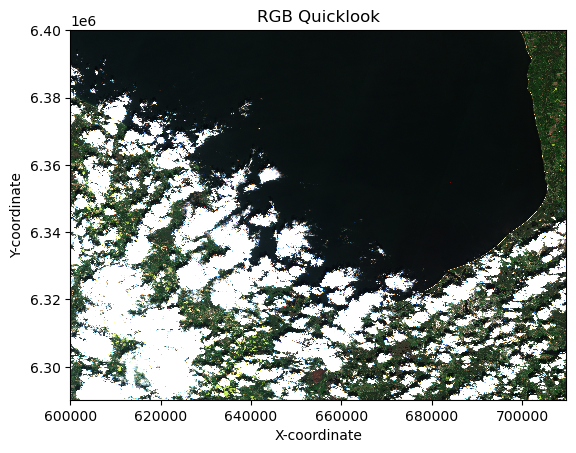

In [19]:
dt['quality/l2a_quicklook/r20m/tci'].plot.imshow()
plt.title('RGB Quicklook')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.grid(False) # Turn off grid for image plots
plt.axis('tight') # Ensure axes fit the data tightly

## Creating our own RGB

For the composite creation, `zarr_meas` contains the assets we are interested in. The TCI composite makes use of the **red** (B04), **green** (B03), and **blue** (B02) bands to create a view that looks natural to the human eye.

Text(0.5, 1.0, 'Red Reflectance (b04)')

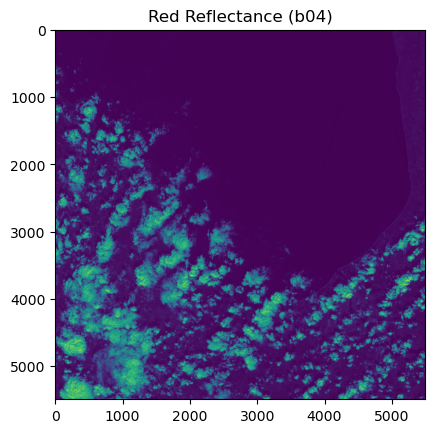

In [20]:
# True colour channels we are interested to retrieve coposite:
tc_red  = 'b04'
tc_green= 'b03'
tc_blue = 'b02'
zarr_meas = dt.measurements.reflectance.r20m

# The tc_red, tc_green, and tc_blue variables are inputs specifying the band names
red = zarr_meas[tc_red]
gre = zarr_meas[tc_green]
blu = zarr_meas[tc_blue]

# Visualising the red band:
plt.imshow(gre)
plt.title('Red Reflectance (b04)')

By this point, we have not accessed the data on disk.
For doing so, we need to call the `.values` function from xarray

In [21]:
# The tc_red, tc_green, and tc_blue variables are inputs specifying the band names
red = zarr_meas[tc_red].values
gre = zarr_meas[tc_green].values
blu = zarr_meas[tc_blue].values

To create the composite image, we need to **normalise** each of the input assets. Normalisation ensures that the bands have a consistent and predictable range of values. This supports optimal data processing and removes the influence of external factors (like changing light conditions) allowing for a meaningful comparison among generated composites.

The `normalisation_str_gm()` function achieves this by scaling the reflectance values to a standard range (0-255) using the percentile-based method.

Once the values for our three bands have been normalised, they can be stacked in an **RGB** format to generate the initial True Colour Image (TCI).

Text(0.5, 1.0, 'RGB Composite')

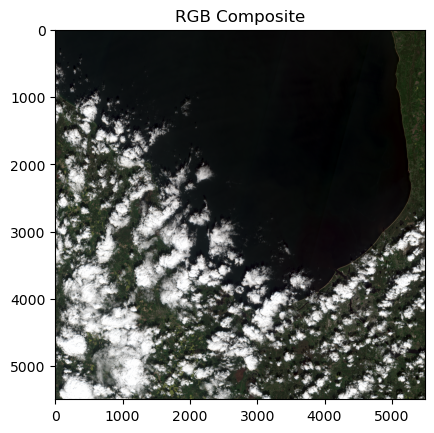

In [22]:
# Input: percentile range for contrast stretching
contrast_stretch_percentile=(2, 98)
# Input: gamma correction value
gamma=1.8

# Apply normalisation to the red, green and blue bands using the specified percentile and gamma values
red_processed = normalisation_str_gm(red, *contrast_stretch_percentile, gamma)
green_processed = normalisation_str_gm(gre, *contrast_stretch_percentile, gamma)
blue_processed = normalisation_str_gm(blu, *contrast_stretch_percentile, gamma)

# We stack the processed red, green, and blue arrays
rgb_composite_sm = np.dstack((red_processed, green_processed, blue_processed)).astype(np.float32)

plt.imshow(rgb_composite_sm)
plt.title('RGB Composite')

## Chunking structure

We can have a look at the reflectance values at 20m resolution chunking strategies by adding `.chunksizes` to the `r20m` group.

In [23]:
zarr_chunks_r20 = dt.measurements.reflectance.r20m.chunksizes
print(zarr_chunks_r20)

Frozen({'/measurements/reflectance/r20m': Frozen({'y': (915, 915, 915, 915, 915, 915), 'x': (915, 915, 915, 915, 915, 915)})})


For exploring each of the x and y dimensions, we retrieve the list for each:

In [24]:
y_values_20 = zarr_chunks_r20['/measurements/reflectance/r20m']['y']
x_values_20 = zarr_chunks_r20['/measurements/reflectance/r20m']['x']

print("Chunking Strategies for r20m:")
print('x # of chunks: ',len(x_values_20))
print('x chunk size : ',x_values_20[0])
print('y # of chunks: ',len(y_values_20))
print('y chunk size : ',y_values_20[0])

Chunking Strategies for r20m:
x # of chunks:  6
x chunk size :  915
y # of chunks:  6
y chunk size :  915


We can also explore `10m` resolution:

In [25]:
zarr_chunks_r10 = dt.measurements.reflectance.r10m.chunksizes
y_values_10 = zarr_chunks_r10['/measurements/reflectance/r10m']['y']
x_values_10 = zarr_chunks_r10['/measurements/reflectance/r10m']['x']

print("Chunking Strategies for r10m:")
print('x # of chunks: ',len(x_values_10))
print('x chunk size : ',x_values_10[0])
print('y # of chunks: ',len(y_values_10))
print('y chunk size : ',y_values_10[0])

Chunking Strategies for r10m:
x # of chunks:  6
x chunk size :  1830
y # of chunks:  6
y chunk size :  1830


And the same for `60m` resolution:

In [26]:
zarr_chunks_r60 = dt.measurements.reflectance.r60m.chunksizes
y_values_60 = zarr_chunks_r60['/measurements/reflectance/r60m']['y']
x_values_60 = zarr_chunks_r60['/measurements/reflectance/r60m']['x']

print("Chunking Strategies for r60m:")
print('x # of chunks: ',len(x_values_60))
print('x chunk size : ',x_values_60[0])
print('y # of chunks: ',len(y_values_60))
print('y chunk size : ',y_values_60[0])

Chunking Strategies for r60m:
x # of chunks:  6
x chunk size :  305
y # of chunks:  6
y chunk size :  305


## 💪 Now it is your turn

- Go to the Jupyter Hub
- Select the `intro_clean.ipynb` version of this notebook.
- Explore this two collections:

### Task 1

#### Sentinel-1 Level-1 GRD over Sicily

- **Starting and ending date:**<br>
    `2025-05-01` to `2025-05-31`
- **Bounding box search:**<br>
    `12.217097,36.537123,15.710750,38.497568`

### Task 2

#### Sentinel-2 L-2A over Vienna

- **Starting and ending date:**<br>
    `2025-04-01` to `2025-04-30`
- **Bounding box search:**<br>
    `16.126524,48.096899,16.660573,48.316752`

### Explore...
- How many items are available?
- Filter the cloud percentage... How many items are still available?
- Recreate an RGB composite for **Sentinel-2 L-2A** over **Vienna**.

<hr>

## Conclusion

In this section we established a connection to the [EOPF Sentinel Zarr Sample Service STAC Catalog](https://stac.browser.user.eopf.eodc.eu/?.language=en) and directly accessed an EOPF Zarr item with `xarray`. In the tutorial you are guided through the process of opening hierarchical EOPF Zarr products using `xarray`'s `DataTree`, a library designed for accessing complex hierarchical data structures.<br>
We also brought data to disk and processed it to obtain an RGB composite, always highlighting the flexibility of data retrieval through **STAC** and the `zarr` format.

<hr>

## What's Next?

In the following section we will explore the application of an **RBG** composite creation a **True Colour Image** from **Sentinel-2 L2A** data for the day of the fire.

To obtain a more detailed overview of a natural event, we will integrate an additional dataset into our workflow: **Sentinel-3** data. This will enable us to analyse thermal information and pinpoint the active fire's location.

<table width="100%" style="padding-top: 10px; text-align: center;">
  <tr>
    <td style="font-size: 0.85em; color: #666; vertical-align: middle;">
      &copy; 2025 <a href="https://zarr.eopf.copernicus.eu/" target="_blank"><strong>EOPF Sentinel Zarr Samples</strong></a> &nbsp;|&nbsp;
      &copy; 2025 <a href="https://github.com/eopf-toolkit" target="_blank"><strong>EOPF Toolkit</strong></a>
      <br><br>
      <img src="../static/EOPF-Toolkit-Sample.png" alt="Project Logo" width="400" style="margin-top: 5px;">
    </td>
  </tr>
</table>